In [1]:
PATH = '../Dataset_GISLR/asl-signs/'
PROCESSED_OUTPUT_PATH = './Dataset_GISLR_Processed/'

In [2]:
import cv2

import numpy as np
import pandas as pd
from PIL import Image

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic
import numpy as np
import matplotlib.pyplot as plt
import math
import json
import os
import concurrent.futures



Iterate over every parquet and do the following:
- Find the first 10 frames that contain a consequtive left or right hand
- Convert the 10 frames into a mediapipe result structure
- Convert each mediapipe result into a numpy array that will be used for training
- Store the numpy array into the folder with the matching label/category/sign

In [3]:
def draw_landmarks(landmarks,image,show_pose=True,show_face_contour=True,show_face_tesselation=True,show_left_hand=True,show_right_hand=True):
    annotated_image = image.copy()
    results = landmarks
    if show_face_tesselation:
        mp_drawing.draw_landmarks(
            annotated_image,
            results.face_landmarks,
            mp_holistic.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_tesselation_style())
    if show_face_contour:
        mp_drawing.draw_landmarks(
            annotated_image,
            results.face_landmarks,
            mp_holistic.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_contours_style())
    if show_pose:
        mp_drawing.draw_landmarks(
            annotated_image,
            results.pose_landmarks,
            mp_holistic.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.
            get_default_pose_landmarks_style())
    if show_left_hand:
        mp_drawing.draw_landmarks(
            annotated_image,
            results.left_hand_landmarks,
            mp_holistic.HAND_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles
            .get_default_hand_landmarks_style())
    if show_right_hand:
        mp_drawing.draw_landmarks(
            annotated_image,
            results.right_hand_landmarks,
            mp_holistic.HAND_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles
            .get_default_hand_landmarks_style())
    return annotated_image

def display_image(img):
    plt.imshow(img)
    plt.axis('off')  # Turn off the axis
    plt.show()

In [4]:
def get_avg(example_landmark):
    filtered_landmarks = example_landmark.dropna(subset=["x", "y", "z"])
    filtered_landmarks = filtered_landmarks[(filtered_landmarks[["x", "y", "z"]] != 0).all(axis=1)]

    # Get the number of landmarks with x, y, z data per type
    landmarks_count = filtered_landmarks["type"].value_counts()
    meta = landmarks_count.to_dict()
    meta["frames"] = filtered_landmarks["frame"].nunique()

    # Identify unique frames with left and right hand landmarks
    left_hand_frames = filtered_landmarks[filtered_landmarks['type'] == 'left_hand']['frame'].nunique()
    right_hand_frames = filtered_landmarks[filtered_landmarks['type'] == 'right_hand']['frame'].nunique()
    print(f"Left hand frames: {left_hand_frames}")
    print(f"Right hand frames: {right_hand_frames}")

In [5]:
from mediapipe.framework.formats import landmark_pb2

class Landmarks(object):
    pass

def get_landmarks_from_parquet(pf,frame):
    f = pf[pf.frame == frame]
    face = landmark_pb2.NormalizedLandmarkList()
    for t in f[f.type=='face'][['x','y','z']].itertuples(index=False):
        face.landmark.add(x=t.x,y=t.y,z=t.z)
    pose = landmark_pb2.NormalizedLandmarkList()
    for t in f[f.type=='pose'][['x','y','z']].itertuples(index=False):
        pose.landmark.add(x=t.x,y=t.y,z=t.z)
    left_hand = landmark_pb2.NormalizedLandmarkList()
    for t in f[f.type=='left_hand'][['x','y','z']].itertuples(index=False):
        left_hand.landmark.add(x=t.x,y=t.y,z=t.z)
    right_hand = landmark_pb2.NormalizedLandmarkList()
    for t in f[f.type=='right_hand'][['x','y','z']].itertuples(index=False):
        right_hand.landmark.add(x=t.x,y=t.y,z=t.z)    
    result = Landmarks()
    result.face_landmarks = face
    result.pose_landmarks = pose
    result.left_hand_landmarks = left_hand
    result.right_hand_landmarks = right_hand
    return result

In [6]:
df = pd.read_csv(PATH + 'train.csv')
df.head()

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


In [7]:
def decide_which_array_to_use(left_hand_frames, right_hand_frames):
    if left_hand_frames and right_hand_frames:
        # right hand is more important
        return right_hand_frames
    elif left_hand_frames:
        return left_hand_frames
    elif right_hand_frames:
        return right_hand_frames
    else:
        return None

def are_landmarks_valid(landmarks):
    return all(not math.isnan(landmark.x) and not math.isnan(landmark.y) and not math.isnan(landmark.z) for landmark in landmarks.landmark)

def display_all_frames(landmarks_array):
    for i in range(len(landmarks_array)):
        if are_landmarks_valid(landmarks_array[i].pose_landmarks):
            annotated_image = np.zeros((1024,1024,3),dtype=np.uint8)
            annotated_image = draw_landmarks(landmarks_array[i],annotated_image)
            display_image(annotated_image)

def find_first_10_consecutive_frames(landmarks_array, hand_type):
    consecutive_frames = []
    first_10_frames = []

    for landmarks in landmarks_array:
        if hand_type == "left":
            has_valid_hand = are_landmarks_valid(landmarks.left_hand_landmarks)
        elif hand_type == "right":
            has_valid_hand = are_landmarks_valid(landmarks.right_hand_landmarks)
        else:
            raise ValueError("Hand type must be 'left' or 'right'")

        if has_valid_hand:
            consecutive_frames.append(landmarks)
            if len(consecutive_frames) == 10:
                first_10_frames = consecutive_frames.copy()
                break
        else:
            consecutive_frames = []

    return first_10_frames

def process_parquet_file(parquet_file):
    pf = pd.read_parquet(PATH + parquet_file)
    frame_numbers = pf.frame.unique()
    landmarks_array = [get_landmarks_from_parquet(pf, frame) for frame in frame_numbers]

    first_10_frames_with_left_hand = find_first_10_consecutive_frames(landmarks_array, "left")
    first_10_frames_with_right_hand = find_first_10_consecutive_frames(landmarks_array, "right")
    chosen_frames = decide_which_array_to_use(first_10_frames_with_left_hand, first_10_frames_with_right_hand)
    return chosen_frames


Sign: minemy


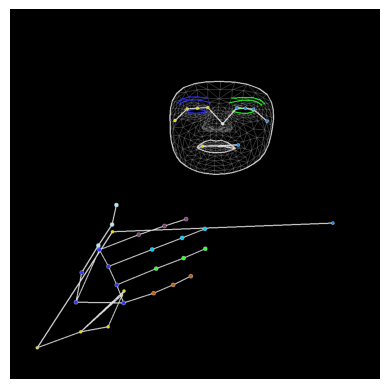

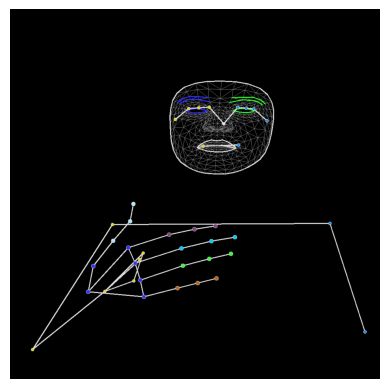

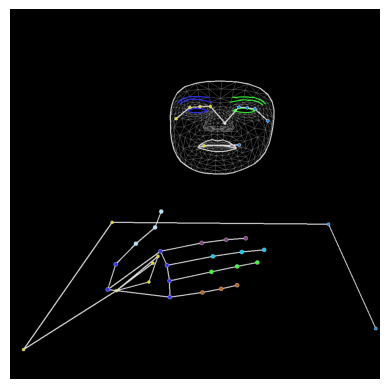

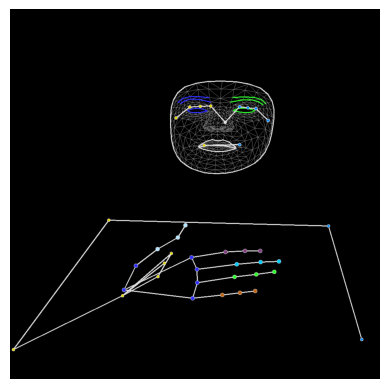

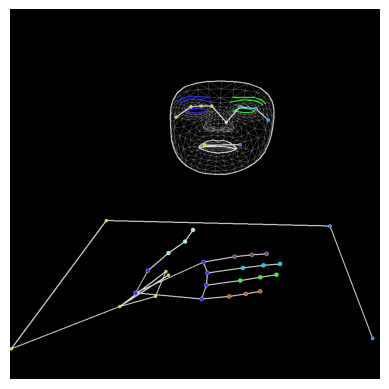

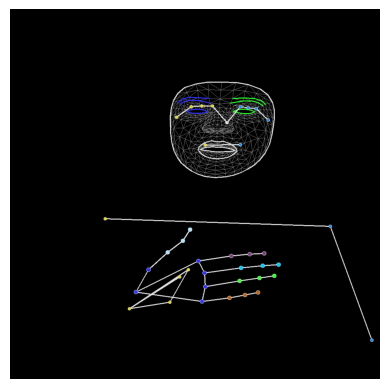

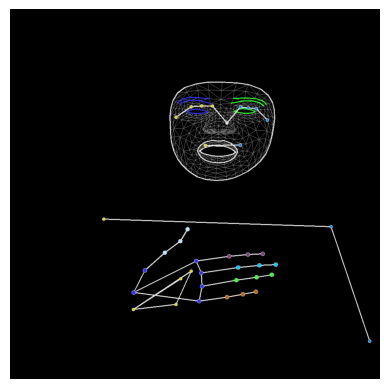

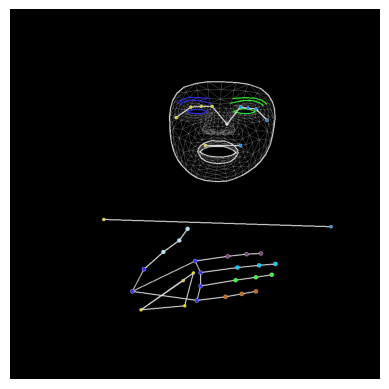

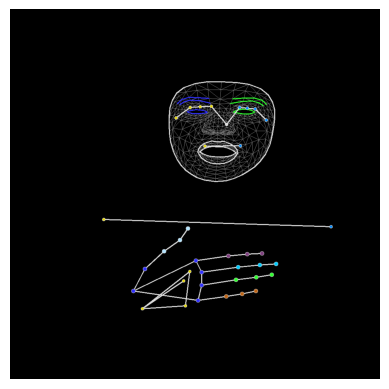

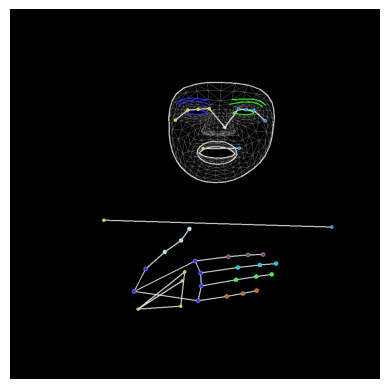

In [8]:
def display_index(index):
    parquet_file = df.iloc[index].path
    print(f"Sign: {df.iloc[index].sign}")
    chosen_frames = process_parquet_file(parquet_file)
    if chosen_frames is None:
        return None
    display_all_frames(chosen_frames)


display_index(6)


In [9]:
def load_json_file(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data
json_file_path = PATH + 'sign_to_prediction_index_map.json'
category_dict = load_json_file(json_file_path)
print(category_dict)

{'TV': 0, 'after': 1, 'airplane': 2, 'all': 3, 'alligator': 4, 'animal': 5, 'another': 6, 'any': 7, 'apple': 8, 'arm': 9, 'aunt': 10, 'awake': 11, 'backyard': 12, 'bad': 13, 'balloon': 14, 'bath': 15, 'because': 16, 'bed': 17, 'bedroom': 18, 'bee': 19, 'before': 20, 'beside': 21, 'better': 22, 'bird': 23, 'black': 24, 'blow': 25, 'blue': 26, 'boat': 27, 'book': 28, 'boy': 29, 'brother': 30, 'brown': 31, 'bug': 32, 'bye': 33, 'callonphone': 34, 'can': 35, 'car': 36, 'carrot': 37, 'cat': 38, 'cereal': 39, 'chair': 40, 'cheek': 41, 'child': 42, 'chin': 43, 'chocolate': 44, 'clean': 45, 'close': 46, 'closet': 47, 'cloud': 48, 'clown': 49, 'cow': 50, 'cowboy': 51, 'cry': 52, 'cut': 53, 'cute': 54, 'dad': 55, 'dance': 56, 'dirty': 57, 'dog': 58, 'doll': 59, 'donkey': 60, 'down': 61, 'drawer': 62, 'drink': 63, 'drop': 64, 'dry': 65, 'dryer': 66, 'duck': 67, 'ear': 68, 'elephant': 69, 'empty': 70, 'every': 71, 'eye': 72, 'face': 73, 'fall': 74, 'farm': 75, 'fast': 76, 'feet': 77, 'find': 78, '

In [12]:
# size of df
print(len(df))
NUM_TO_TRAIN = len(df)
print(NUM_TO_TRAIN)

94477
94477


In [13]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])


def process_and_save_sequences(index, output_folder):
    parquet_file = df.iloc[index].path
    label = df.iloc[index].sign
    name = df.iloc[index].sequence_id

    label_folder = os.path.join(output_folder, label)
    os.makedirs(label_folder, exist_ok=True)

    # make file name with name
    file_name = str(name) + ".npy"
    seq_file = os.path.join(label_folder, file_name)
    # print(f"Processing {seq_file}...")

    # check if file exists
    if os.path.isfile(seq_file):
        # print(f"File {seq_file} already exists. Skipping...")
        return None

    chosen_frames = process_parquet_file(parquet_file)
    if chosen_frames is None:
        return None
    
    window = []
    for frame in chosen_frames:
        window.append(extract_keypoints(frame))
    
    np.save(seq_file, np.array(window))

max_threads = os.cpu_count()  # Specify the number of threads you want to use
print(f"Using {max_threads} threads")
with concurrent.futures.ThreadPoolExecutor(max_workers=max_threads) as executor:
    futures = {executor.submit(process_and_save_sequences, i, PROCESSED_OUTPUT_PATH): i for i in range(NUM_TO_TRAIN)}
    concurrent.futures.wait(futures)
    

Using 16 threads
